In [76]:
%matplotlib inline
import pathlib as pl
import numpy as np
import sys
import xugrid
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

import rasterio.warp
from shapely.geometry import shape

import scipy.sparse as sparse

import flopy
import flopy.plot.styles as styles

from gdptools import WeightGenP2P

In [77]:
# path = r"D:\LISS_GW\GitRepo_CoupledModels\nywsc_compound_flooding\dflow-fm\coarse\tides_2018\run\output\FlowFM_map.nc"
# source_ds = xugrid.open_dataset(path)
# dflowdf = gpd.GeoDataFrame(geometry = gpd.points_from_xy(source_ds.mesh2d_node_x , source_ds.mesh2d_node_y), crs = 'EPSG:32618')
# dflowdf.explore()

In [78]:
sys.path.append("../common")
from liss_settings import cx, cx_provider, extent, boxx, boxy, get_dflow_grid_name, get_modflow_coupling_tag, get_modflow_grid_name

In [79]:
control_path = pl.Path("../dflow-fm/coarse/tides_2018/base/FlowFM.mdu") # change this if using a different D-Flow FM control file
grid_name = get_dflow_grid_name(control_path)
print(grid_name)

LIS_GPT_PJ_cells3_net


In [80]:
# # BNB note, can this b changed to PJ model name?
# mf_grid_name = get_modflow_grid_name()
# print(mf_grid_name)

## Read the D-Flow FM output file

Make sure you run D-Flow FM by itself first so that there is an output NetCDF file available so that the mapping is done using the internal node order

In [81]:
# use an output file because this is what will be available from bmi and is in the correct order
source_path = "../dflow-fm/coarse/tides_2018/FlowFM_map.nc"
source_ds = xugrid.open_dataset(source_path)

In [82]:
dflowdf = gpd.GeoDataFrame(geometry = gpd.points_from_xy(source_ds.mesh2d_node_x , source_ds.mesh2d_node_y), crs = 'EPSG:32618')
# dflowdf.explore()

In [83]:
print(source_ds.grid.face_node_connectivity.shape)
source_ds.grid.face_node_connectivity

(21660, 4)


array([[13296,     0,     1,  -999],
       [    3,     2,     0,  -999],
       [    1,     0,     2,  -999],
       ...,
       [13295, 13291, 13287, 13293],
       [13288, 13291, 13290, 13286],
       [13295, 13294, 13290, 13291]], dtype=int64)

In [84]:
print(source_ds.grid.node_face_connectivity.shape)
source_ds.grid.node_face_connectivity

(13365, 21660)


<13365x21660 sparse matrix of type '<class 'numpy.int32'>'
	with 68795 stored elements in Compressed Sparse Row format>

### Convert the NetCDF data to a geodataframe

In [85]:
source_gdf = source_ds["mesh2d_nFaces"].ugrid.to_geodataframe(name="cell")
source_gdf.shape

(21660, 4)

In [86]:
source_gdf.set_crs(32618, inplace=True)

,cell,mesh2d_face_x,mesh2d_face_y,geometry
mesh2d_nFaces,,,,
0,0,581304.782862,4.530140e+06,"POLYGON ((581278.095 4530797.658, 580803.668 4..."
1,1,580948.525069,4.529244e+06,"POLYGON ((580509.155 4529024.860, 581120.782 4..."
2,2,581165.501727,4.529318e+06,"POLYGON ((581637.189 4529571.190, 580803.668 4..."
3,3,580708.393782,4.528634e+06,"POLYGON ((580509.155 4529024.860, 580305.524 4..."
4,4,581718.153967,4.528955e+06,"POLYGON ((581930.574 4528371.125, 581637.189 4..."
...,...,...,...,...
21655,21655,698004.338382,4.540132e+06,"POLYGON ((697883.097 4539946.737, 698216.083 4..."
21656,21656,698641.288943,4.539406e+06,"POLYGON ((698946.834 4539209.344, 698783.296 4..."
21657,21657,697760.020796,4.539259e+06,"POLYGON ((698001.058 4539041.376, 697939.776 4..."


## Open the shapefile with the location of the coastal boundaries in MODFLOW

The shapefile needs to be limited to coastal boundary locations and be in the same coordinate system as the D-Flow FM model (UTM 18N).

In [87]:
fpth = f"../modflow/gis/PJ/PJ_ghb_utm18n.shp"
print(fpth)

../modflow/gis/PJ/PJ_ghb_utm18n.shp


In [88]:
target_coastal = gpd.read_file(fpth) # this is the shapefile with coastal boundary conditions
print(target_coastal.shape)
print(target_coastal.crs)

(354, 9)
EPSG:32618


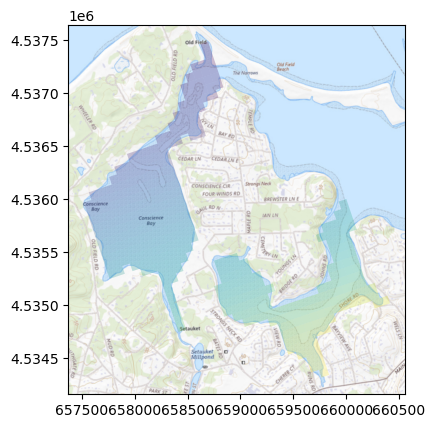

In [89]:
ax = target_coastal.plot(alpha=0.25, column="ghb_no")
cx.add_basemap(ax, crs=target_coastal.crs, attribution=False, source=cx_provider)

In [90]:
target_coastal.shape[0]

354

## Create the D-FLOW FM to GHB mapping

In [91]:
# generate the weights
weight_gen = WeightGenP2P(
    target_poly=target_coastal,
    target_poly_idx="ghb_no",
    source_poly=source_gdf,
    source_poly_idx=["cell"],
    method="serial",
    weight_gen_crs=32618,
)
weights = weight_gen.calculate_weights()
#weights['ghb_no'] = weights['ghb_no'].astype(float)
weights['ghb_no'] = weights['ghb_no']

Using serial engine
Reprojecting to epsg:EPSG:32618 finished in 0.0 second(s)
Validating polygons
     - validating source polygons
     - fixing 0 invalid polygons.
     - validating target polygons
     - fixing 0 invalid polygons.
Validate polygons finished in 0.0271 seconds
Intersections finished in 0.0229 seconds
Weight gen finished in 0.0503 seconds


In [92]:
check = weights['ghb_no'].drop_duplicates()
assert len(check) == target_coastal.shape[0]

In [93]:
map_shape = (target_coastal.shape[0], source_gdf.shape[0])
map_shape

(354, 21660)

In [94]:
dflow2mfghb = np.zeros(map_shape, dtype=float)
print(f"{dflow2mfghb.shape}\n{dflow2mfghb}")

(354, 21660)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [95]:
for r,c,v in zip(weights["ghb_no"], weights["cell"], weights["wght"]):
    print(r,c,v)
    dflow2mfghb[int(r),int(c)] = v

# assert dflow2mfghb.shape == (target_coastal.shape[0], source_gdf.shape[0])

0 10950 0.06825577328841141
0 10772 0.012052037619300234
0 10591 0.055586341219098445
0 11130 0.19969298159287227
0 10774 0.23443116724610175
0 10952 0.4299816990315491
1 10950 0.09358267122883829
1 10772 0.6616243874762253
1 10591 0.2447929412985248
2 10951 0.004609271555507786
2 10950 0.9953907284472473
3 10950 0.35018353764008237
3 10772 0.6498164623648928
4 10772 0.9999089891941706
4 10591 9.101080560093511e-05
5 10773 0.2739181098947853
5 10951 0.7260818901063455
6 10773 0.09050989920298147
6 10590 0.022080796957833833
6 10589 0.07823068397469007
6 10951 0.21054126496903527
6 10950 0.3801969203002
6 10772 0.21844043459252283
7 10589 0.08480552154622777
7 10950 0.00018217711959478552
7 10772 0.9150123013321653
8 10589 0.004122932200862921
8 10772 0.9958770678004781
9 10773 1.0000000000000002
10 10773 0.9312255237823127
10 10590 0.0687744762178594
11 10773 0.09455537924716989
11 10590 0.7217902971300373
11 10589 0.18365432362096187
12 10590 0.0045480159392079
12 10589 0.995451984060

## Create the ghb masking array

Where the sums of the weights along a row are not equal to ~1.0

In [96]:
mask_idx = np.isclose(dflow2mfghb.sum(axis=1), 1.0)
print(f"{mask_idx.sum()}\n{mask_idx.shape}\n{mask_idx}")

assert mask_idx.shape[0] == target_coastal.shape[0]

354
(354,)
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  Tr

In [97]:
print(target_coastal.shape[0], mask_idx.shape[0])
assert mask_idx.shape[0] == target_coastal.shape[0]

354 354


### Test the D-FLOW FM to GHB mapping

In [98]:
s = np.full(source_gdf.shape[0], 1.0)
h = np.full(mask_idx.shape, 2.0)
h[mask_idx] = dflow2mfghb.dot(s)[mask_idx]
s.shape, dflow2mfghb.shape, h.shape

((21660,), (354, 21660), (354,))

In [99]:
print(f"{h.sum()}\n{h}")

354.00000000002007
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1

#### Test with a nan

In [100]:
s = np.random.random(source_gdf.shape[0])
s[1544] = -1e30
print(s)

[0.17275308 0.36316481 0.85925485 ... 0.85881676 0.77911943 0.85100567]


In [101]:
h = np.full(mask_idx.shape, 2.0)
h = dflow2mfghb.dot(s)
h.shape

(354,)

In [102]:
print(f"{h.sum()}\n{h}")

187.11569123981738
[0.6347562  0.41789948 0.51280177 0.40546896 0.34807397 0.68575151
 0.54298082 0.37382175 0.349305   0.69170202 0.69023784 0.66896137
 0.65163597 0.64280093 0.67619455 0.67842919 0.67041247 0.65745223
 0.6424414  0.38700567 0.57555905 0.71705828 0.69511857 0.67100558
 0.40864441 0.42325946 0.7107931  0.88151209 0.85148162 0.51576407
 0.59575982 0.74468142 0.5473533  0.46066464 0.50238124 0.4567921
 0.55943956 0.6064216  0.34817466 0.31674166 0.49031437 0.53773023
 0.61802682 0.28937522 0.23653418 0.24120348 0.30721923 0.6804265
 0.47509822 0.27422616 0.28376969 0.39727009 0.6115969  0.62834317
 0.7605849  0.74320626 0.39833848 0.15567216 0.14528032 0.48895683
 0.84527824 0.83362322 0.95700251 0.95700251 0.95397168 0.7898398
 0.54749234 0.37603191 0.26485022 0.2440035  0.78993993 0.82924235
 0.86208397 0.82768833 0.77823482 0.72878141 0.67932808 0.618057
 0.34980945 0.34462474 0.33745607 0.585948   0.77651748 0.78458113
 0.8437624  0.01727918 0.01727918 0.01727918 0.0

## Create the GHB to Qext mapping

In [103]:
ghb2qext = np.transpose(dflow2mfghb.copy())

### Test the GHB to Qext mapping

In [104]:
q = np.full(ghb2qext.shape[1], 1.0)

In [105]:
qext = ghb2qext.dot(q)

In [106]:
print(f"{qext.sum()}\n{qext.shape}")

354.00000000002
(21660,)


## Save the mapping arrays

In [107]:
assert dflow2mfghb.shape == (target_coastal.shape[0], source_gdf.shape[0])

In [108]:
assert mask_idx.shape[0] == target_coastal.shape[0]

In [109]:
assert ghb2qext.shape == (source_gdf.shape[0], target_coastal.shape[0])

In [110]:
mf_grid_name = 'PJmf6'

fpath = f"../mapping/PJ/dflow_{grid_name}_to_{mf_grid_name}_ghb.npz"
np.savez_compressed(fpath, dflow2mfghb=dflow2mfghb, ghbmask=mask_idx, ghb2qext=ghb2qext)